#  This document is the exploratory data analysis for problems of anomaly with some of Sysmex's analyzers

## Part 1: Exploratory Data Analysis

This part is to explore data, transform and understand the data provided by Sysmex

In [1]:
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import numpy.random as rnd
import os
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split 
import findspark
findspark.init()
import pyspark
from pyspark.sql.functions import *

# to make this notebook's output stable across runs
from IPython.display import display, HTML

from tensorflow.python.framework import random_seed

rnd.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rnn"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "events", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)


In [2]:
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("W205 Final") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

In [3]:
#Load csv data to spark frame objects (distributed) and create columns names for these dataframe objects. You can replace these 
#loading code with hive table loading to load to hive tables. 
test_flagging = spark.read.csv('data/Sysmex/Data/Test Flagging Query Data Set.csv', header =False)
test_flagging = test_flagging.select(col("_c0").alias("Prod_ID"), col("_c1").alias("Count_Date"), col("_c2").alias("IPU_Ver"),col("_c3").alias("Count_Val"), col("_c4").alias("Counter") )

qc_raw = spark.read.csv('data/Sysmex/Data/Specific QC Lot Number Results.csv', header =False)
qc_raw = qc_raw.select(col("_c0").alias("Prod_ID"), col("_c1").alias("QC_Lot"), col("_c2").alias("QC_Time"),col("_c3").alias("W-X"), col("_c4").alias("W-Y"),col("_c5").alias("W-Z") )

machine_raw = spark.read.csv('data/Sysmex/Data/Reference Set A Result Set.csv')
machine_raw = machine_raw.select(col("_c0").alias("Prod_ID"), col("_c1").alias("Ser_No"), col("_c2").alias("Model_ID"),col("_c3").alias("IPU_Ver"), col("_c4").alias("Upgrade_Date") )
x_bar_raw = spark.read.csv('data/Sysmex/Data/XBarM Result Set for Steve (CSV Form Revised).csv', header = False)
x_bar_raw = x_bar_raw.select(col("_c0").alias("Prod_ID"), col("_c1").alias("X_Bar_Run_Date_Time"), col("_c2").alias("X_Bar_M_X"),col("_c3").alias("X_Bar_M_Y"), col("_c4").alias("X_Bar_M_Z") )


In [4]:
#Store dataframe data to tables (Parquet format) so that we can later on we can refer to data in this warehouse
test_flagging.write.saveAsTable("Flagging_Raw")
qc_raw.write.saveAsTable("QC_Raw")
machine_raw.write.saveAsTable("Machine_Raw")
x_bar_raw.write.saveAsTable("XBar_Raw")


In [5]:
#Now we perform data joining to construct data objets that we need.
#First, we want a QC data object that have not only QC data but also machine data with it. We also
#Clean out null records from the data

#To prepare to retrieve the right IPU_Version for each QC or Flagging transaction, we will create new columns start_date and end date 
#in hat cover the valid time range for a particular IPU. One particular time range is determined to start from the 
#effective date of the software IPU Version to the next effective date if any. If there's no effective date of the  
#IPU Version then IPU_Ver is set to None. A dummy value of'12/31/2017' is for any transactions that happens after the last upgrade
#date to mean the IPU to use the latest IPU_Ver
#To do this 
qc_sql = spark.sql("select QC_Raw.*, X.IPU_Ver, X.Model_ID, X.Ser_No from QC_Raw left join (select A.Prod_ID, A.Ser_No, A.Model_ID, A.IPU_Ver, UNIX_TIMESTAMP(A.Upgrade_Date, 'MM/dd/yy hh:mm aa') Start_Date, case when B.Upgrade_Date !='None' THEN  unix_timestamp(B.Upgrade_Date, 'MM/dd/yy hh:mm aa') \
                        ELSE UNIX_TIMESTAMP('12/31/17 12:00 PM','MM/dd/yy hh:mm aa') END End_Date, B.IPU_Ver end_IPU from (Select *, rank()  over(partition by Prod_ID order by unix_timestamp(Upgrade_Date, 'MM/dd/yy hh:mm aa') \
                        ) rank from Machine_Raw) A left join (Select *, rank()  over(partition by Prod_ID order by unix_timestamp(Upgrade_Date, 'MM/dd/yy hh:mm aa') ) \
                        rank from Machine_Raw) B on A.Prod_ID = B.Prod_ID  and (A.rank = B.rank-1)) X on QC_Raw.Prod_ID = X.Prod_ID \
                        and UNIX_TIMESTAMP(QC_Raw.QC_Time, 'yyyy-MM-dd hh:mm:ss')>=X.Start_Date and UNIX_TIMESTAMP(QC_Raw.QC_Time, 'yyyy-MM-dd hh:mm:ss')<X.End_Date")


qc_data =qc_sql.toPandas()


In [6]:
#Doing the same thing as above for XBar data
x_bar_sql = spark.sql("select XBar_Raw.*, X.IPU_Ver,X.Model_ID, X.Ser_No from XBar_Raw left join (select A.Prod_ID, A.Ser_No, A.Model_ID, A.IPU_Ver, UNIX_TIMESTAMP(A.Upgrade_Date, 'MM/dd/yy hh:mm aa') Start_Date, case when B.Upgrade_Date !='None' THEN  unix_timestamp(B.Upgrade_Date, 'MM/dd/yy hh:mm aa') \
                        ELSE UNIX_TIMESTAMP('12/31/17 12:00 PM','MM/dd/yy hh:mm aa') END End_Date, B.IPU_Ver end_IPU from (Select *, rank()  over(partition by Prod_ID order by unix_timestamp(Upgrade_Date, 'MM/dd/yy hh:mm aa') \
                        ) rank from Machine_Raw) A left join (Select *, rank()  over(partition by Prod_ID order by unix_timestamp(Upgrade_Date, 'MM/dd/yy hh:mm aa') ) \
                        rank from Machine_Raw) B on A.Prod_ID = B.Prod_ID  and (A.rank = B.rank-1)) X on XBar_Raw.Prod_ID = X.Prod_ID \
                        and UNIX_TIMESTAMP(XBar_Raw.X_Bar_Run_Date_Time, 'yyyy-MM-dd hh:mm:ss')>=X.Start_Date and UNIX_TIMESTAMP(XBar_Raw.X_Bar_Run_Date_Time, 'yyyy-MM-dd hh:mm:ss')<X.End_Date")
x_bar_m = x_bar_sql.toPandas()

In [7]:
#Doing the same thing as above for Flagging data

test_flagging_sql = spark.sql("select Flagging_Raw.*, X.IPU_Ver,X.Model_ID, X.Ser_No from Flagging_Raw left join (select A.Prod_ID, A.Ser_No, A.Model_ID, A.IPU_Ver, UNIX_TIMESTAMP(A.Upgrade_Date, 'MM/dd/yy hh:mm aa') Start_Date, case when B.Upgrade_Date !='None' THEN  unix_timestamp(B.Upgrade_Date, 'MM/dd/yy hh:mm aa') \
                        ELSE UNIX_TIMESTAMP('12/31/17 12:00 PM','MM/dd/yy hh:mm aa') END End_Date, B.IPU_Ver end_IPU from (Select *, rank()  over(partition by Prod_ID order by unix_timestamp(Upgrade_Date, 'MM/dd/yy hh:mm aa') \
                        ) rank from Machine_Raw) A left join (Select *, rank()  over(partition by Prod_ID order by unix_timestamp(Upgrade_Date, 'MM/dd/yy hh:mm aa') ) \
                        rank from Machine_Raw) B on A.Prod_ID = B.Prod_ID  and (A.rank = B.rank-1)) X on Flagging_Raw.Prod_ID = X.Prod_ID \
                        and UNIX_TIMESTAMP(Flagging_Raw.Count_Date, 'yyyy-MM-dd')>=X.Start_Date and UNIX_TIMESTAMP(Flagging_Raw.Count_Date, 'yyyy-MM-dd')<X.End_Date")
# test_flagging_sql = spark.sql("select Flagging_Raw.* from Flagging_Raw limit 20")


test_flagging = test_flagging_sql.toPandas()

In [8]:
print('number of records in QC data with zero W-Z, W-Y, W-Z data {:10,d}'.format(np.sum((qc_data['W-X']=='0')&(qc_data['W-Y']=='0')&(qc_data['W-Z']=='0'))))
print('number of records in XBar data with zero W-Z, W-Y, W-Z data {:10,d}'.format(np.sum((x_bar_m['X_Bar_M_X']=='0')&(x_bar_m['X_Bar_M_Y']=='0')&(x_bar_m['X_Bar_M_Z']=='0'))))

number of records in QC data with zero W-Z, W-Y, W-Z data     18,071
number of records in XBar data with zero W-Z, W-Y, W-Z data          0


In [9]:
#This code is to clean up data (remove all zero records) and transfer to the type so that we can manipulate with Pandas

qc_data = qc_data[((qc_data['W-X']!='0')&(qc_data['W-Y']!='0')&(qc_data['W-Z']!='0'))]
qc_data['Prod_ID'] = qc_data['Prod_ID'].astype(str)
qc_data['W-X'] = qc_data['W-X'].astype(int)
qc_data['W-Y'] = qc_data['W-Y'].astype(int)
qc_data['W-Z'] = qc_data['W-Z'].astype(int)
qc_data['QC_Time'] = pd.to_datetime(qc_data['QC_Time'])
qc_data[['Ser_No', 'Model_ID']] = qc_data[['Ser_No', 'Model_ID']].bfill()
qc_data['IPU_Ver'] = qc_data['IPU_Ver'].fillna(value ='unknown_ver')

test_flagging['Prod_ID'] = test_flagging.Prod_ID.astype(str)
test_flagging['Count_Date'] = pd.to_datetime(test_flagging.Count_Date)
test_flagging['Count_Val'] = test_flagging['Count_Val'].astype(int)
test_flagging[['Ser_No', 'Model_ID']] = test_flagging[['Ser_No', 'Model_ID']].bfill()
test_flagging['IPU_Ver'] = test_flagging['IPU_Ver'].fillna(value ='unknown_ver')


x_bar_m['Prod_ID'] = x_bar_m.Prod_ID.astype(str)
x_bar_m['X_Bar_Run_Date_Time'] = pd.to_datetime(x_bar_m.X_Bar_Run_Date_Time)

x_bar_m['X_Bar_M_X'] = x_bar_m['X_Bar_M_X'].astype(int)
x_bar_m['X_Bar_M_Y'] = x_bar_m['X_Bar_M_Y'].astype(int)
x_bar_m['X_Bar_M_Z'] = x_bar_m['X_Bar_M_Z'].astype(int)
x_bar_m[['Ser_No', 'Model_ID']] = x_bar_m[['Ser_No', 'Model_ID']].bfill()
x_bar_m['IPU_Ver'] = x_bar_m['IPU_Ver'].fillna(value ='unknown_ver')




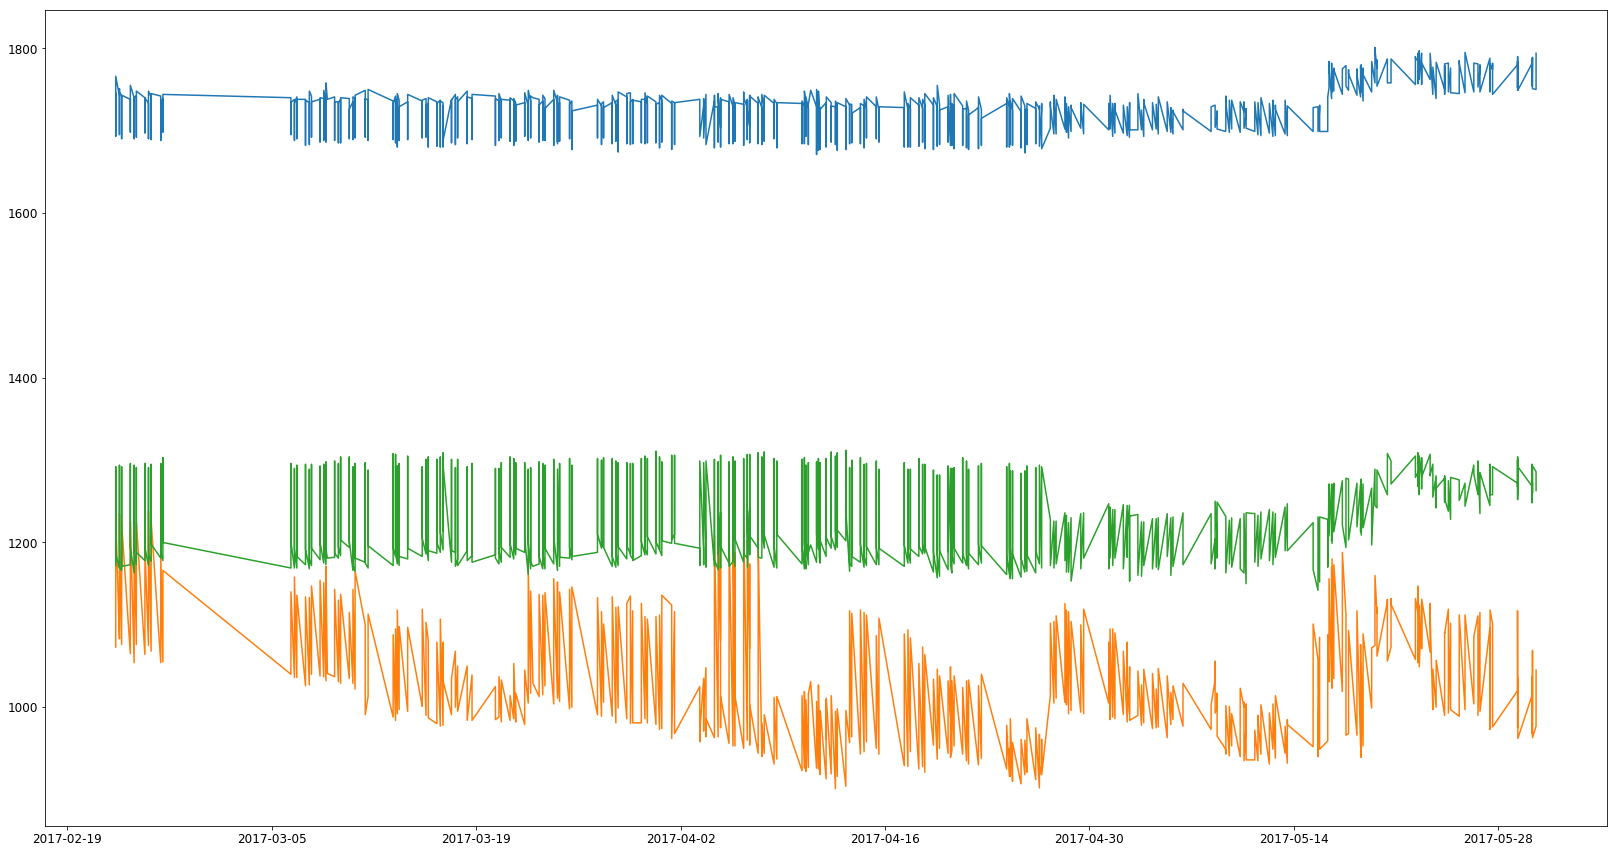

In [24]:
#Test with a plot to show time series data
t =qc_data[qc_data.Prod_ID =='148359'].sort_values('QC_Time')
fig, ax = plt.subplots(figsize =(28,15))


ax.plot(t.QC_Time, t['W-X'])
ax.plot(t.QC_Time, t['W-Y'])
ax.plot(t.QC_Time, t['W-Z'])


In [30]:
qc_data[qc_data.Prod_ID=='164186']

,Prod_ID,QC_Lot,QC_Time,W-X,W-Y,W-Z,IPU_Ver,Model_ID,Ser_No
14745,164086,QC-70371102,2017-04-06 07:04:36,1754,1015,1262,unknown_ver,XN-11,A1026
14746,164086,QC-70371102,2017-04-06 18:00:21,1752,1003,1268,unknown_ver,XN-11,A1026
14747,164086,QC-70371102,2017-04-07 07:04:31,1756,1023,1268,unknown_ver,XN-11,A1026
14748,164086,QC-70371102,2017-04-07 18:28:43,1752,1033,1263,unknown_ver,XN-11,A1026
14749,164086,QC-70371102,2017-04-08 06:53:54,1762,1049,1266,unknown_ver,XN-11,A1026
14750,164086,QC-70371102,2017-04-09 00:25:55,1759,1034,1265,unknown_ver,XN-11,A1026
14751,164086,QC-70371102,2017-04-10 10:21:21,1761,1056,1266,unknown_ver,XN-11,A1026
14752,164086,QC-70371102,2017-04-10 18:40:25,1757,1046,1271,unknown_ver,XN-11,A1026
14753,164086,QC-70371102,2017-04-11 08:32:12,1754,1038,1267,unknown_ver,XN-11,A1026
14754,164086,QC-70371102,2017-04-11 18:39:25,1757,1039,1263,unknown_ver,XN-11,A1026


In [12]:
#Summary data from test flagging
test_flagging[['Prod_ID','Count_Date', 'IPU_Ver', 'Counter']].describe()

,Prod_ID,Count_Date,IPU_Ver,IPU_Ver,Counter
count,4957240,4957240,4957240,4957240,4957240
unique,3681,146,17,13,11
top,126556,2017-05-19 00:00:00,00-16 (Build 7),unknown_ver,CBCCounter
freq,244802,42509,3108178,3138131,973334
first,NaN,2017-01-01 00:00:00,NaN,NaN,NaN
last,NaN,2017-05-26 00:00:00,NaN,NaN,NaN


In [13]:
#We may consider rewriting this with spark. 
def shift_date(x):
    x =x.sort_values('Count_Date')
    values= x['max'].copy().values
    values[1:] = values[0:len(values)-1]
    x['max'] = x['max'].values - values
   
    return x

X =test_flagging[(test_flagging.Counter!='CBCCounter')&(test_flagging.Counter!='DIFFCounter')].groupby(['Prod_ID', 'Counter','Count_Date'])['Count_Val'].aggregate(['max']).reset_index().groupby(['Prod_ID', 'Counter']).apply(shift_date)

# data_flagging_ver01 = X.unstack().fillna(0)

# data_flagging_ver01['Total_Flag'] = data_flagging_ver01.AtypicalLymphIPCounter + data_flagging_ver01.DimorphicPopulationIPCounter+ data_flagging_ver01.IGPresentIPCounter + data_flagging_ver01.LeftShiftIPCounter + data_flagging_ver01.PLTAbnDistribIPCounter+ data_flagging_ver01.RETAbnSctIPCounter + data_flagging_ver01.WBCAbnSctCounter
# data_flagging_ver01 =data_flagging_ver01.reset_index(level=[0, 1, 2])

# data_flagging_ver02 =data_flagging_ver01[data_flagging_ver01.WBModeCounter>0]

# data_flagging_ver02['AtypicalLymphIPCounter'] = data_flagging_ver02.AtypicalLymphIPCounter/data_flagging_ver02.WBModeCounter


# data_flagging_ver02['DimorphicPopulationIPCounter'] = data_flagging_ver02.DimorphicPopulationIPCounter/data_flagging_ver02.WBModeCounter
# data_flagging_ver02['IGPresentIPCounter'] = data_flagging_ver02.IGPresentIPCounter/data_flagging_ver02.WBModeCounter
# data_flagging_ver02['LeftShiftIPCounter'] = data_flagging_ver02.LeftShiftIPCounter/data_flagging_ver02.WBModeCounter


# data_flagging_ver02['PLTAbnDistribIPCounter'] = data_flagging_ver02.PLTAbnDistribIPCounter/data_flagging_ver02.WBModeCounter
# data_flagging_ver02['PLTAbnSctIPCounter'] = data_flagging_ver02.PLTAbnSctIPCounter/data_flagging_ver02.WBModeCounter


# data_flagging_ver02['RETAbnSctIPCounter'] = data_flagging_ver02.RETAbnSctIPCounter/data_flagging_ver02.WBModeCounter
# data_flagging_ver02['WBCAbnSctCounter'] = data_flagging_ver02.WBCAbnSctCounter/data_flagging_ver02.WBModeCounter
# data_flagging_ver02['Total_Flag'] = data_flagging_ver02.AtypicalLymphIPCounter + data_flagging_ver02.DimorphicPopulationIPCounter+ data_flagging_ver02.IGPresentIPCounter + data_flagging_ver02.LeftShiftIPCounter + data_flagging_ver02.PLTAbnDistribIPCounter+ data_flagging_ver02.RETAbnSctIPCounter + data_flagging_ver02.WBCAbnSctCounter






In [ ]:
bar_data_label =data_flagging_ver02.groupby('IPU_Ver')['Total_Flag'].mean().sort_values()

In [ ]:
bar_data =bar_data_label.values
bar_labels =bar_data_label.index

In [ ]:
bar_data_label.index

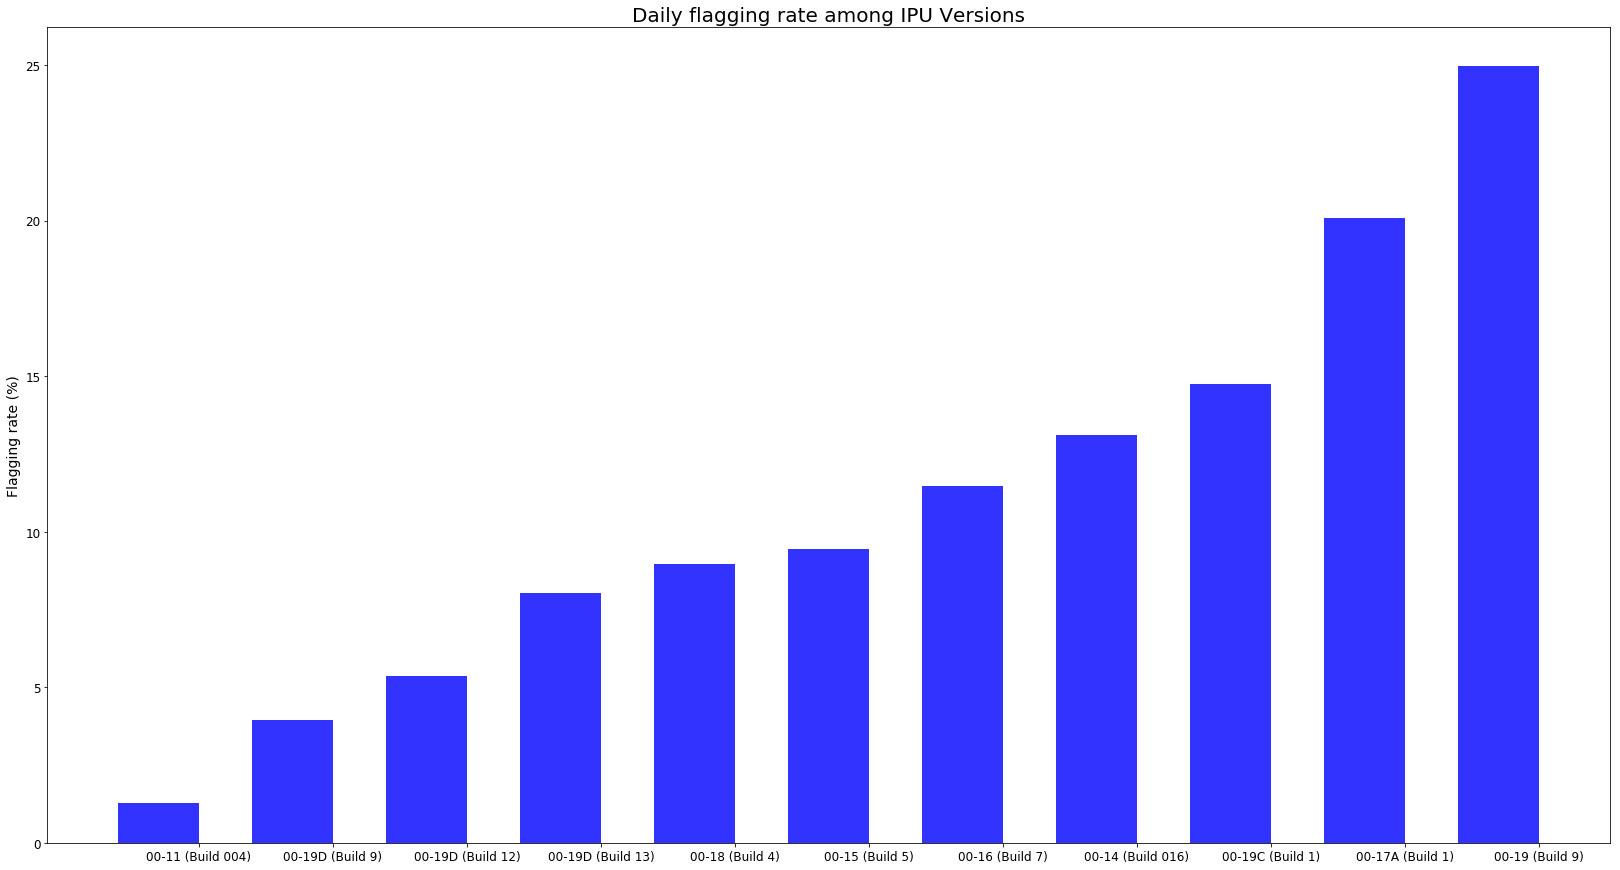

In [86]:
n_groups =len(bar_data)
index = np.arange(n_groups)
bar_width = 0.6
opacity = 0.8



fig, ax = plt.subplots(figsize =(28,15))
ax.set_ylabel('Flagging rate (%)')
ax.set_title('Daily flagging rate among IPU Versions',fontsize=20)
ax.set_xticks(index + bar_width / 2)

rects1 = ax.bar(index, 100*bar_data, bar_width,
                 alpha=opacity,
                 color='b',
                 label='Flag rates among IPU')
ax.set_xticklabels(bar_labels)
plt.show()

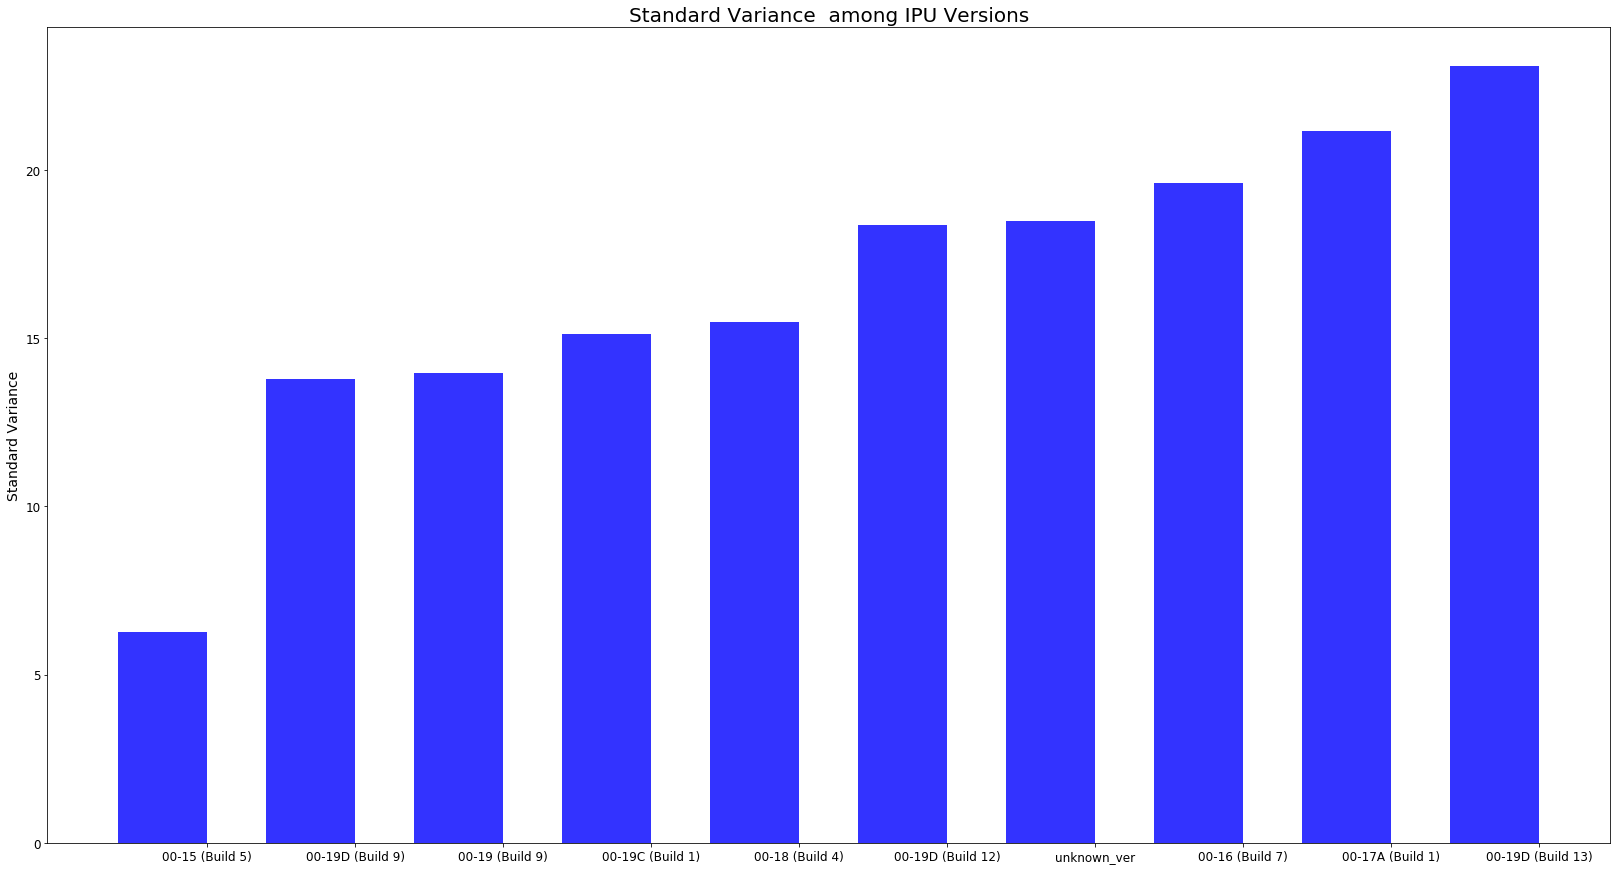

In [14]:
xbar_graph_data =x_bar_m.groupby(['IPU_Ver'])['X_Bar_M_X','X_Bar_M_Y', 'X_Bar_M_Z'].aggregate(np.std).mean(axis=1).sort_values()
xbar_bar_data =xbar_graph_data.values
xbar_bar_labels =xbar_graph_data.index

xbar_n_groups =len(xbar_bar_data)
xbar_index = np.arange(xbar_n_groups)
bar_width = 0.6
opacity = 0.8



fig_xbar, ax_xbar = plt.subplots(figsize =(28,15))
ax_xbar.set_ylabel('Standard Variance')
ax_xbar.set_title('Standard Variance  among IPU Versions',fontsize=20)
ax_xbar.set_xticks(xbar_index + bar_width / 2)

rects2 = ax_xbar.bar(xbar_index, xbar_bar_data, bar_width,
                 alpha=opacity,
                 color='b',
                 label='Standard Variance  among IPUs')
ax_xbar.set_xticklabels(xbar_bar_labels)
plt.show()

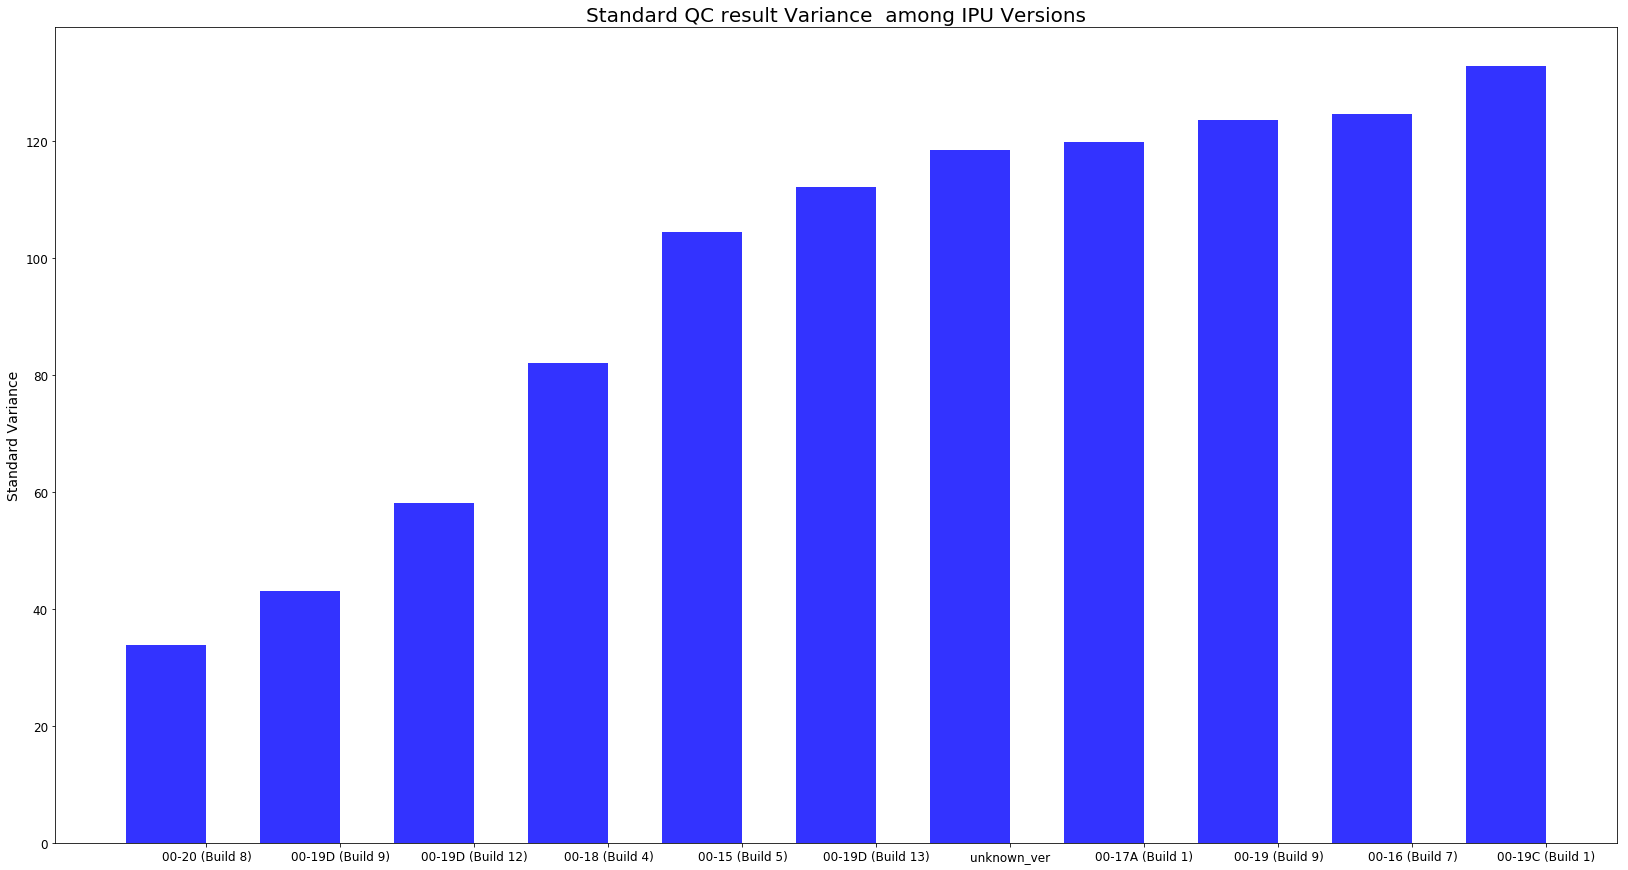

In [15]:
qc_graph_data=qc_data.groupby(['IPU_Ver'])['W-X','W-Y', 'W-Z'].aggregate(np.std).mean(axis =1).sort_values()

qc_bar_data =qc_graph_data.values
qc_bar_labels =qc_graph_data.index

qc_n_groups =len(qc_bar_data)
qc_index = np.arange(qc_n_groups)
bar_width = 0.6
opacity = 0.8



fig_qc, ax_qc = plt.subplots(figsize =(28,15))
ax_qc.set_ylabel('Standard Variance')
ax_qc.set_title('Standard QC result Variance  among IPU Versions',fontsize=20)
ax_qc.set_xticks(qc_index + bar_width / 2)

rects2 = ax_qc.bar(qc_index, qc_bar_data, bar_width,
                 alpha=opacity,
                 color='b',
                 label='Standard Variance  among IPUs')
ax_qc.set_xticklabels(qc_bar_labels)
plt.show()

## Prediction Algorithm Development

In [16]:
train_data = transformed_qc_data
test_data = transformed_qc_data

train_xbar_data = transformed_xbar_m
test_xbar_data = transformed_xbar_m




In [35]:

def format_test_data(test_data, n_steps):
    X = []
    Y = []
    max_test_range = test_data.shape[0]

    for start in range(max_test_range//n_steps):
        
        ys1 = test_data[start*n_steps: start*n_steps+n_steps]
        ys2 = test_data[start*n_steps+1: start*n_steps+n_steps+1,0:3]
        X.append(ys1)
        Y.append(ys2)
        
    X = np.array(X).reshape(-1, n_steps, 41)
    Y = np.array(Y).reshape(-1, n_steps, 3)
    return X, Y 
   

In [36]:
class DataSet(object):

  def __init__(self,
               data,
               indices,
               n_steps,
               seed=None):
    seed1, seed2 = random_seed.get_seed(seed)
    # If op level seed is not set, use whatever graph level seed is returned
    np.random.seed(seed1 if seed is None else seed2)
    self._num_examples = int(len(indices)/n_steps)
    self._indices = indices
#     self._labels = labels
    self._n_steps = n_steps
    self._data = data

    self._epochs_completed = 0
    self._index_in_epoch = 0

  @property
  def indices(self):
    return self._indices


  @property
  def n_steps(self):
    return self._n_steps

  @property
  def num_examples(self):
    return self._num_examples
  @property
  def data(self):
    return self._data


  @property
  def epochs_completed(self):
    return self._epochs_completed


  def load(self, indices=[], batch_size=30):
    n_events= np.zeros(shape=(batch_size,self._n_steps,41), dtype=np.uint8)
    m_events= np.zeros(shape=(batch_size,self._n_steps,3), dtype=np.uint8)

    
    for i,j in zip(indices,range(batch_size)):
#         print("start is", start)
#         print("end is", end)
#         print("i is", i)
#         print("")

        n_event = self._data[i*self._n_steps:(i+1)*self._n_steps]
        n_events[j] = np.array(n_event)
        m_event = self._data[i*self._n_steps+1:(i+1)*self._n_steps+1,0:3]
        m_events[j] = np.array(m_event)
    return n_events, m_events
   

  def next_batch(self, batch_size, shuffle=True):
    """Return the next `batch_size` examples from this data set."""
    start = self._index_in_epoch
    # Shuffle for the first epoch
    if self._epochs_completed == 0 and start == 0 and shuffle:
      perm0 = np.arange(self._num_examples)
      np.random.shuffle(perm0)
      self._indices = self.indices[perm0]
    # Go to the next epoch
    if start + batch_size > self._num_examples:
      # Finished epoch
      self._epochs_completed += 1
      # Get the rest examples in this epoch
      rest_num_examples = self._num_examples - start
      events_rest_part = self._indices[start:self._num_examples]
      # Shuffle the data
      if shuffle:
        perm = np.arange(self._num_examples)
        np.random.shuffle(perm)
        self._indices = self.indices[perm]
      # Start next epoch
      start = 0
      self._index_in_epoch = batch_size - rest_num_examples
      end = self._index_in_epoch
      events_new_part = self._indices[start:end]

      return self.load(np.concatenate((events_rest_part, events_new_part), axis =0), batch_size)
    else:
      self._index_in_epoch += batch_size
      end = self._index_in_epoch
        
#     n_events= np.zeros(shape=(batch_size,self._n_steps,41), dtype=np.uint8)
#     m_events= np.zeros(shape=(batch_size,self._n_steps,3), dtype=np.uint8)

    
#     for i,j in zip(range(start,end),range(batch_size)):
# #         print("start is", start)
# #         print("end is", end)
# #         print("i is", i)
# #         print("")

#         n_event = self._data[i*self._n_steps:(i+1)*self._n_steps]
#         n_events[j] = np.array(n_event)
#         m_event = self._data[i*self._n_steps+1:(i+1)*self._n_steps+1,0:3]
#         m_events[j] = np.array(m_event)
    return self.load((start,end), batch_size)


        

In [37]:
qc_events_data = DataSet(train_data,np.arange(0,2000000), 300)



In [20]:

def format_xbar_test_data(test_data, n_steps):
    X = []
    Y = []
    max_xbar_test_range = test_xbar_data.shape[0]

    for start in range(max_xbar_test_range//n_steps):
        
        ys1 = test_xbar_data[start*n_steps: start*n_steps+n_steps]
        ys2 = test_xbar_data[start*n_steps+1: start*n_steps+n_steps+1,0:3]
        X.append(ys1)
        Y.append(ys2)
        
    X = np.array(X).reshape(-1, n_steps, 16)
    Y = np.array(Y).reshape(-1, n_steps, 3)
    return X, Y 
   

In [38]:
tf.reset_default_graph()

n_steps = 300
n_inputs = 41
n_neurons = 100
n_outputs = 3
learning_rate = 0.001



X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

cell = tf.contrib.rnn.OutputProjectionWrapper(
    tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu),
    output_size=n_outputs)
outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)


loss = tf.reduce_sum(tf.square(outputs - y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

In [55]:
n_epochs = 50
sm_batch_size = 50
# sm_n_steps = 300
saver = tf.train.Saver()

with tf.Session() as sess:
    
    for epoch in range(n_epochs):

        init.run()
        for iteration in range(qc_events_data.num_examples // sm_batch_size):
            X_batch, y_batch = qc_events_data.next_batch(sm_batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            if iteration % 10 == 0:
                mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
                print(iteration, "\tMSE:", mse)

    save_path = saver.save(sess, "/tmp/my_model_final.ckpt")


0 	MSE: 5.62218e+07
10 	MSE: 8.36028e+06
20 	MSE: 4.81236e+06
30 	MSE: 7.39474e+06
40 	MSE: 6.50932e+06
50 	MSE: 4.78463e+06
60 	MSE: 4.3554e+06
70 	MSE: 5.08265e+06
80 	MSE: 3.48733e+06
90 	MSE: 2.57055e+06
100 	MSE: 2.54567e+06
110 	MSE: 2.95494e+06
120 	MSE: 3.65105e+06
130 	MSE: 3.07031e+06
0 	MSE: 5.12516e+07
10 	MSE: 1.28579e+07
20 	MSE: 5.6694e+06
30 	MSE: 4.80627e+06
40 	MSE: 6.70892e+06
50 	MSE: 3.26895e+06
60 	MSE: 4.97082e+06
70 	MSE: 5.25295e+06
80 	MSE: 3.07255e+06
90 	MSE: 3.11085e+06
100 	MSE: 3.24637e+06
110 	MSE: 4.19929e+06
120 	MSE: 2.52392e+06
130 	MSE: 6.2813e+06
0 	MSE: 7.85194e+07
10 	MSE: 2.64765e+07
20 	MSE: 7.35826e+06
30 	MSE: 4.74286e+06
40 	MSE: 5.94573e+06
50 	MSE: 5.43476e+06
60 	MSE: 4.8912e+06
70 	MSE: 3.89720e+06
80 	MSE: 4.63606e+06
90 	MSE: 2.79088e+06
100 	MSE: 2.87749e+06
110 	MSE: 2.91248e+06
120 	MSE: 2.70255e+06
130 	MSE: 3.82175e+06
0 	MSE: 4.28767e+07
10 	MSE: 1.04257e+07
20 	MSE: 6.74685e+06
30 	MSE: 5.14556e+06
40 	MSE: 2.45183e+06
50 	MSE: 

In [42]:
with tf.Session() as sess:
    saver.restore(sess,"/tmp/my_model_final.ckpt")
    X_test, Y_test = format_test_data(test_data, 300)
    y_pred = sess.run(outputs, feed_dict={X: X_test})
    mse = loss.eval(feed_dict={X: X_test, y: Y_test})





INFO:tensorflow:Restoring parameters from /tmp/my_model_final.ckpt


In [52]:
actual = Y_test.reshape(-1,3)
pred = y_pred.reshape(-1,3)
var = 1/3*(np.abs(actual[:,0]-pred[:,0])+np.abs(actual[:,1]-pred[:,1])+np.abs(actual[:,2]-pred[:,2]))


x=np.argwhere(var>np.percentile(var,99.995)).reshape(-1)

actual[x,:]

array([[1770, 1283, 1236],
       [1783, 1291, 1223],
       [1771, 1323, 1225],
       [1797, 1279, 1223],
       [1765, 1332, 1216],
       [1768, 1323, 1230],
       [1781, 1311, 1207],
       [1779, 1322, 1228],
       [1776, 1302, 1238],
       [1796, 1279, 1208],
       [1787, 1313, 1200],
       [1661, 1196, 1585],
       [1776, 1310, 1220],
       [1772, 1276, 1238],
       [1761, 1272, 1246],
       [1778, 1330, 1195],
       [1766, 1307, 1215],
       [1612, 1157, 1674],
       [1770, 1256, 1258],
       [1780, 1338, 1210],
       [1764, 1313, 1238],
       [1784, 1276, 1267],
       [1767, 1262, 1259],
       [1802, 1245, 1237],
       [1793, 1302, 1176],
       [1778, 1290, 1215],
       [1775, 1305, 1224],
       [1794, 1266, 1228],
       [1769, 1286, 1241],
       [1802, 1252, 1230],
       [1778, 1259, 1243],
       [1766, 1303, 1267],
       [1758, 1309, 1235],
       [1775, 1330, 1241],
       [1763, 1361, 1191],
       [1781, 1303, 1202],
       [1784, 1276, 1231],
 

In [53]:
machines = qc_data.iloc[x+1]
HTML(machines.to_html())

,Prod_ID,QC_Lot,QC_Time,W-X,W-Y,W-Z,IPU_Ver,Model_ID,Ser_No
12618,153956,QC-70381101,2017-03-15 14:59:58,1770,1283,1236,unknown_ver,XN-10,20595
30630,137783,QC-70381101,2017-03-01 12:53:56,1783,1291,1223,unknown_ver,XN-10,14148
38130,153126,QC-70381101,2017-03-01 11:31:10,1771,1323,1225,unknown_ver,XN-10,20576
48667,137755,QC-70381101,2017-03-09 14:38:50,1797,1279,1223,unknown_ver,XN-10,12124
58267,138880,QC-70381101,2017-02-21 11:03:29,1765,1332,1216,unknown_ver,XN-10,14257
58567,138880,QC-70941101,2017-04-15 07:35:48,1768,1323,1230,unknown_ver,XN-10,14257
74864,146636,QC-70941101,2017-04-18 06:58:57,1781,1311,1207,00-19D (Build 13),XN-10,16836
99931,155609,QC-70381101,2017-03-13 23:44:55,1779,1322,1228,unknown_ver,XN-10,22276
111896,154714,QC-70381101,2017-03-02 06:43:54,1776,1302,1238,unknown_ver,XN-10,20502
113096,166532,QC-70941101,2017-04-21 15:39:14,1796,1279,1208,unknown_ver,XN-10,25438


In [ ]:

plt.plot(range(len(Y_test[0][:,0])),Y_test[0][:,0], color ='b', label ="Actual")

plt.plot(range(len(X_test[0][:,0])),y_pred[0][:,0], color='r',  label ="Prediction")
plt.legend(loc="upper left")
plt.xlabel("Time")
plt.ylabel("W-X Value")

In [ ]:


plt.plot(range(len(Y_test[1][:,1])),Y_test[1][:,1], color ='b', label ="Actual")

plt.plot(range(len(X_test[1][:,1])),y_pred[1][:,1], color='r',  label ="Prediction")
plt.legend(loc="upper left")
plt.xlabel("Time")
plt.ylabel("W-Y Value")

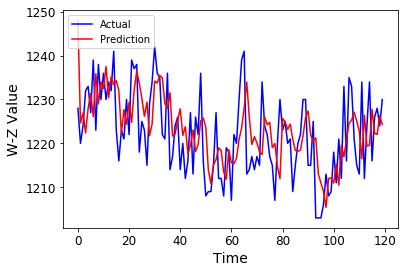

In [237]:

plt.plot(range(len(Y_test[1][:,2])),Y_test[1][:,2], color ='b', label ="Actual")

plt.plot(range(len(X_test[1][:,2])),y_pred[1][:,2], color='r',  label ="Prediction")
plt.legend(loc="upper left")
plt.xlabel("Time")
plt.ylabel("W-Z Value")



In [238]:

plt.plot(range(len(Y_xbar_test[0][:,0])),Y_xbar_test[0][:,0], color ='b', label ="Actual")

plt.plot(range(len(X_xbar_test[0][:,0])),y_xbar_pred[0][:,0], color='r',  label ="Prediction")
plt.legend(loc="upper left")
plt.xlabel("Time")
plt.ylabel("W-X Value")